# Exploratory data analysis of TCGA mutation data

In [1]:
import os

import numpy
import pandas
import seaborn

%matplotlib inline

## Read TCGA datasets

In [2]:
path = os.path.join('data', 'mutation-matrix.tsv.bz2')
mutation_df = pandas.read_table(path, index_col=0)
mutation_df.columns.name = 'entrez_gene_id'
mutation_df.shape

(8756, 20224)

In [3]:
path = os.path.join('data', 'samples.tsv')
sample_df = pandas.read_table(path)
sample_df.head(2)

,sample_id,patient_id,acronym,disease,age_diagnosed,gender,race,ajcc_stage,clinical_stage,histological_type,...,dead,days_survived,disease_specific_survival_status,disease_specific_survival_days,disease_free_interval_status,disease_free_interval_days,progression_free_interval_status,progression_free_interval_days,sample_type,n_mutations
0,TCGA-02-0047-01,TCGA-02-0047,GBM,glioblastoma multiforme,78.0,Male,White,NaN,NaN,Untreated primary (de novo) GBM,...,1.0,448.0,1.0,448.0,NaN,NaN,1.0,57.0,Primary Solid Tumor,64
1,TCGA-02-0055-01,TCGA-02-0055,GBM,glioblastoma multiforme,62.0,Female,White,NaN,NaN,Untreated primary (de novo) GBM,...,1.0,76.0,1.0,76.0,NaN,NaN,1.0,6.0,Primary Solid Tumor,51


## Distribution of mutations counts for genes

In [4]:
gene_df = mutation_df.sum(axis='rows').rename('n_mutations').reset_index()
gene_df['n_mutations_log1p'] = numpy.log1p(gene_df.n_mutations)
gene_df.head(2)

,entrez_gene_id,n_mutations,n_mutations_log1p
0,1,57,4.060443
1,2,226,5.424950


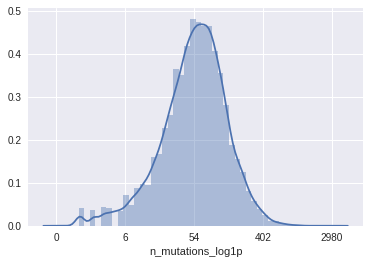

In [5]:
ax = seaborn.distplot(gene_df.n_mutations_log1p)
xticks = ax.get_xticks()
xticklabels = numpy.expm1(xticks).round().astype(int)
axis_texts = ax.set_xticklabels(xticklabels)

In [6]:
sum(gene_df.n_mutations == 0)

2

## Distribution of mutations counts for samples

In [7]:
sample_df = sample_df.merge(
    mutation_df.sum(axis='columns').rename('n_mutations').reset_index()
)
sample_df['n_mutations_log1p'] = numpy.log1p(sample_df.n_mutations)
sample_df.head(2)

,sample_id,patient_id,acronym,disease,age_diagnosed,gender,race,ajcc_stage,clinical_stage,histological_type,...,days_survived,disease_specific_survival_status,disease_specific_survival_days,disease_free_interval_status,disease_free_interval_days,progression_free_interval_status,progression_free_interval_days,sample_type,n_mutations,n_mutations_log1p
0,TCGA-02-0047-01,TCGA-02-0047,GBM,glioblastoma multiforme,78.0,Male,White,NaN,NaN,Untreated primary (de novo) GBM,...,448.0,1.0,448.0,NaN,NaN,1.0,57.0,Primary Solid Tumor,64,4.174387
1,TCGA-02-0055-01,TCGA-02-0055,GBM,glioblastoma multiforme,62.0,Female,White,NaN,NaN,Untreated primary (de novo) GBM,...,76.0,1.0,76.0,NaN,NaN,1.0,6.0,Primary Solid Tumor,51,3.951244


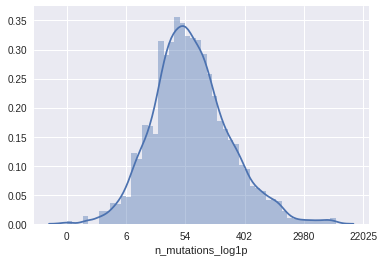

In [8]:
# Mutations per sample
ax = seaborn.distplot(sample_df.n_mutations_log1p)
xticks = ax.get_xticks()
xticklabels = numpy.expm1(xticks).round().astype(int)
axis_texts = ax.set_xticklabels(xticklabels)

## Diagnosis age versus mutation count for samples

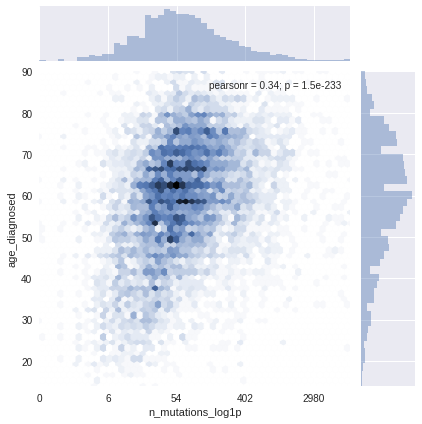

In [9]:
grid = seaborn.jointplot('n_mutations_log1p', 'age_diagnosed', data=sample_df, kind='hex')
xticks = grid.ax_marg_x.get_xticks()
xticklabels = numpy.expm1(xticks).round().astype(int)
axis_texts = grid.ax_marg_x.set_xticklabels(xticklabels)

## Mutation frequency by disease

In [10]:
genes = mutation_df.columns.tolist()
verbose_mutation_df = sample_df.merge(mutation_df.reset_index())
mutation_freq_df = verbose_mutation_df.groupby('disease').apply(lambda df: df[genes].mean(axis='rows')).assign(
    n_mutations = verbose_mutation_df.groupby('disease').apply(len)
)
mutation_freq_df.iloc[:3, :3]

,1,2,9
disease,,,
adrenocortical cancer,0.000000,0.000000,0.000000
bladder urothelial carcinoma,0.009926,0.034739,0.007444
brain lower grade glioma,0.001961,0.007843,0.001961


In [11]:
verbose_mutation_df.head()

,sample_id,patient_id,acronym,disease,age_diagnosed,gender,race,ajcc_stage,clinical_stage,histological_type,...,105372481,105375355,105379427,106479339,106479938,106660612,107133494,107133516,107984923,109731405
0,TCGA-02-0047-01,TCGA-02-0047,GBM,glioblastoma multiforme,78.0,Male,White,NaN,NaN,Untreated primary (de novo) GBM,...,0,0,0,0,0,0,0,0,0,0
1,TCGA-02-0055-01,TCGA-02-0055,GBM,glioblastoma multiforme,62.0,Female,White,NaN,NaN,Untreated primary (de novo) GBM,...,0,0,0,0,0,0,0,0,0,0
2,TCGA-02-2483-01,TCGA-02-2483,GBM,glioblastoma multiforme,43.0,Male,Asian,NaN,NaN,Untreated primary (de novo) GBM,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-02-2485-01,TCGA-02-2485,GBM,glioblastoma multiforme,53.0,Male,Black Or African American,NaN,NaN,Untreated primary (de novo) GBM,...,0,0,0,0,0,0,0,0,0,0
4,TCGA-02-2486-01,TCGA-02-2486,GBM,glioblastoma multiforme,64.0,Male,White,NaN,NaN,Untreated primary (de novo) GBM,...,0,0,0,0,0,0,0,0,0,0


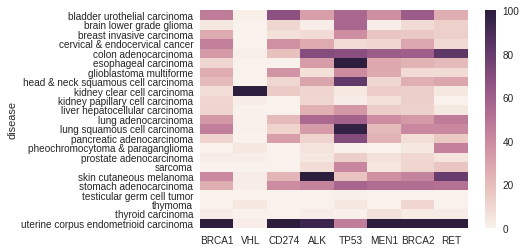

In [12]:
gene_subset = {
    '7157': 'TP53', # tumor protein p53
    '7428': 'VHL', # von Hippel-Lindau tumor suppressor
    '29126': 'CD274', # CD274 molecule
    '672': 'BRCA1', # BRCA1, DNA repair associated
    '675': 'BRCA2', # BRCA2, DNA repair associated
    '238': 'ALK', # anaplastic lymphoma receptor tyrosine kinase
    '4221': 'MEN1', # menin 1
    '5979': 'RET', # ret proto-oncogene 
}
plot_df = (mutation_freq_df
    .query("n_mutations > 100")
    [list(gene_subset)]
    .rename(columns=gene_subset)
)

# Convert to percent of max mutation rate for gene
plot_df = 100 * plot_df.divide(plot_df.max())
ax = seaborn.heatmap(plot_df)